In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical


import os
import cv2

def resize_image(image_path):
    # Load the image and resize it to 128,128
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
    return img

def read_dataset(dataset_path):
    # Create a list to store all the images
    images = []
    # Create a list to store the labels
    labels = []
    # Loop through the folders in the dataset path
    for folder in os.listdir(dataset_path):
        # Check if the folder is either 'Testing' or 'Training'
        if folder in ['Testing', 'Training']:
            # Create the path to the folder
            folder_path = os.path.join(dataset_path, folder)
            # Loop through the sub-folders in the folder
            for sub_folder in os.listdir(folder_path):
                # Check if the sub-folder is one of the four categories
                if sub_folder in ['glioma', 'meningioma', 'notumor', 'pituitary']:
                    # Create the path to the sub-folder
                    sub_folder_path = os.path.join(folder_path, sub_folder)
                    # Loop through the images in the sub-folder
                    for image_file in os.listdir(sub_folder_path):
                        # Check if the image is a .jpg file
                        if image_file.endswith('.jpg'):
                            # Create the path to the image
                            image_path = os.path.join(sub_folder_path, image_file)
                            # Resize the image and add it to the list of images
                            images.append(resize_image(image_path))
                            # Add the label to the list of labels
                            labels.append(sub_folder)
    return images, labels


# Call the read_dataset function to read the dataset
images, labels = read_dataset('/content/drive/MyDrive/MODELS_MRI/mri')

target = ['glioma', 'meningioma', 'notumor', 'pituitary']

def text_to_index(text_labels):
    index_labels = []
    for label in text_labels:
        index_labels.append(target.index(label))
    return index_labels

labels = text_to_index(labels)


images=np.array(images)
labels=np.array(labels)
print(images.shape,labels.shape)

print(labels)

from sklearn.model_selection import train_test_split
# Split the images and labels into training and testing sets, with a  test size
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42,stratify=labels)

X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7086, 128, 128, 3) (7086,)
[2 2 2 ... 1 1 1]
(5668, 128, 128, 3) (1418, 128, 128, 3) (5668,) (1418,)


In [2]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [3]:

y_train = to_categorical(y_train)
print(f"Label size {y_train.shape}")
y_test = to_categorical(y_test)
print(f"Label size {y_test.shape}")

Label size (5668, 4)
Label size (1418, 4)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

# Load ResNet model
resnet_tf1 = load_model('/content/drive/MyDrive/MODELS_MRI/resnet-tf1.h5')

# Load ResNet with TF model
resnet_tf2 = load_model('/content/drive/MyDrive/MODELS_MRI/resnet-tf2.h5')

# Load VGG16 model
vgg16_tf1 = load_model('/content/drive/MyDrive/MODELS_MRI/vgg16-tf1.h5')

# Load VGG16 with TF model
vgg16_tf2 = load_model('/content/drive/MyDrive/MODELS_MRI/vgg16-tf2.h5')

# Load Inception model
inception_tf1 = load_model('/content/drive/MyDrive/MODELS_MRI/inception-tf1.h5')
# Load Inception with TF model
inception_tf2 = load_model('/content/drive/MyDrive/MODELS_MRI/inception-tf2.h5')
# Load VGG16 with TF model
vgg16_not_tf = load_model('/content/drive/MyDrive/MODELS_MRI/vgg16-not-tf.h5')

# Load Inception model
inception_not_tf = load_model('/content/drive/MyDrive/MODELS_MRI/inception-not-tf.h5')

resnet_not_tf= load_model('/content/drive/MyDrive/MODELS_MRI/resnet-not-tf.h5')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,cohen_kappa_score

def evaluate_model(model, X_test, y_test, labels):
    # Make predictions on test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate the metrics
    loss, accuracy = model.evaluate(X_test, y_test)
    precision = accuracy_score(y_test_labels, y_pred_labels)*100
    kappa = cohen_kappa_score(y_test_labels, y_pred_labels)*100
    classification = classification_report(y_test_labels, y_pred_labels, target_names=labels)
    confusion = confusion_matrix(y_test_labels, y_pred_labels)
    accuracy=accuracy*100

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Confusion Matrix")
    plt.show()

    # Print the classification report
    print("Classification Report:\n", classification)

    # Print the metrics
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Kappa Score: {kappa:.4f}")

    return loss, accuracy, precision, kappa, confusion, classification
# Define the list of labels for the four classes
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']


45/45 [==============================] - 3s 38ms/step - loss: 0.8592 - accuracy: 0.6834


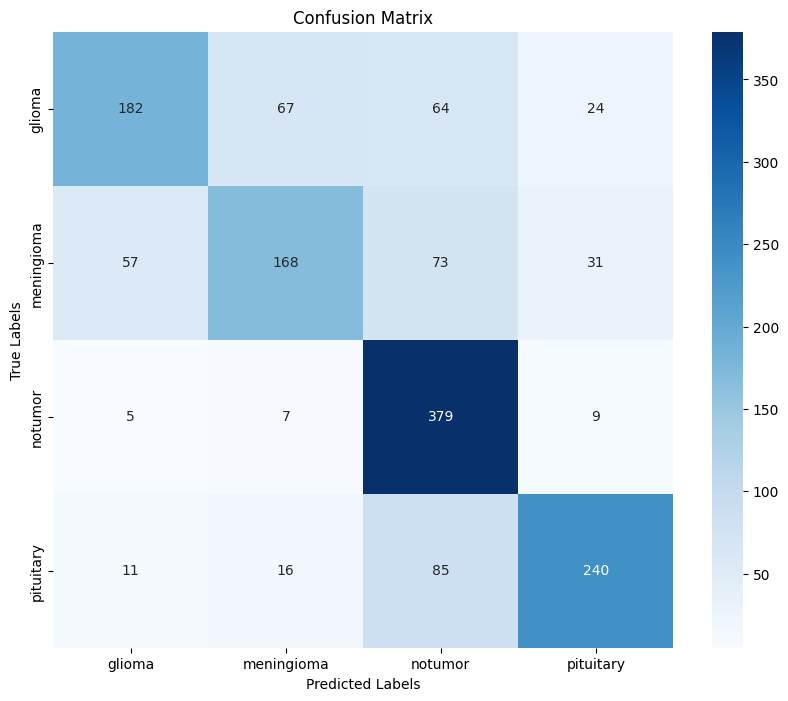

Classification Report:
               precision    recall  f1-score   support

      glioma       0.71      0.54      0.61       337
  meningioma       0.65      0.51      0.57       329
     notumor       0.63      0.95      0.76       400
   pituitary       0.79      0.68      0.73       352

    accuracy                           0.68      1418
   macro avg       0.70      0.67      0.67      1418
weighted avg       0.69      0.68      0.67      1418

Loss: 0.8592
Accuracy: 68.3357
Precision: 68.3357
Kappa Score: 57.3412


In [6]:
# Evaluate the models
resnet_loss, resnet_accuracy, resnet_precision, resnet_kappa, confusion_resnet, classification_resnet = evaluate_model(resnet_tf1, X_test, y_test, labels)


45/45 [==============================] - 3s 36ms/step - loss: 0.0770 - accuracy: 0.9795


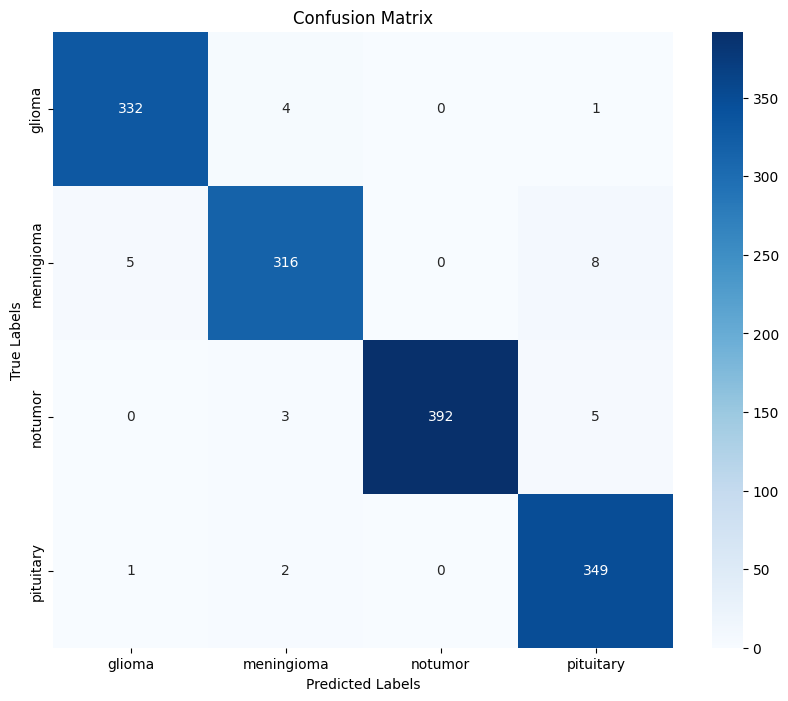

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.99      0.98       337
  meningioma       0.97      0.96      0.97       329
     notumor       1.00      0.98      0.99       400
   pituitary       0.96      0.99      0.98       352

    accuracy                           0.98      1418
   macro avg       0.98      0.98      0.98      1418
weighted avg       0.98      0.98      0.98      1418

Loss: 0.0770
Accuracy: 97.9549
Precision: 97.9549
Kappa Score: 97.2682


In [7]:
resnet_tf_loss, resnet_tf_accuracy, resnet_tf_precision, resnet_tf_kappa, confusion_resnet_tf, classification_resnet_tf = evaluate_model(resnet_tf2, X_test, y_test, labels)


45/45 [==============================] - 2s 40ms/step - loss: 0.4137 - accuracy: 0.8843


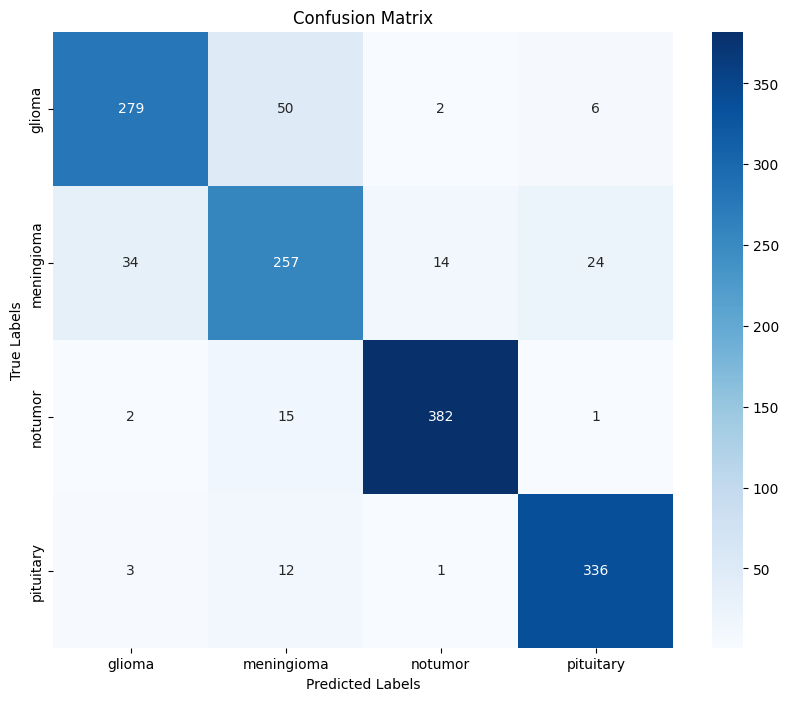

Classification Report:
               precision    recall  f1-score   support

      glioma       0.88      0.83      0.85       337
  meningioma       0.77      0.78      0.78       329
     notumor       0.96      0.95      0.96       400
   pituitary       0.92      0.95      0.93       352

    accuracy                           0.88      1418
   macro avg       0.88      0.88      0.88      1418
weighted avg       0.88      0.88      0.88      1418

Loss: 0.4137
Accuracy: 88.4344
Precision: 88.4344
Kappa Score: 84.5469


In [8]:
vgg16_loss, vgg16_accuracy, vgg16_precision, vgg16_kappa, confusion_vgg16, classification_vgg16 = evaluate_model(vgg16_tf1, X_test, y_test, labels)


45/45 [==============================] - 2s 40ms/step - loss: 0.0373 - accuracy: 0.9887


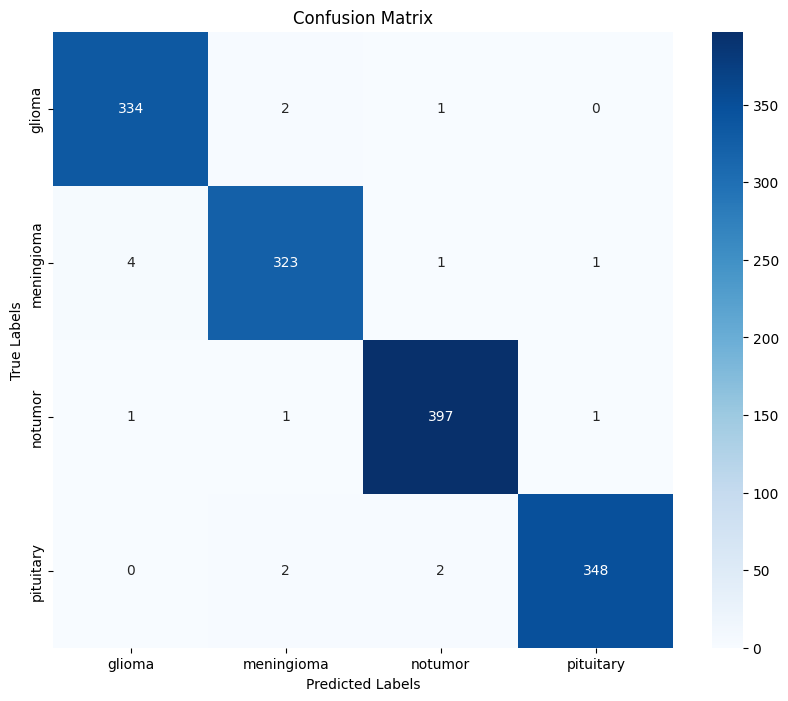

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       337
  meningioma       0.98      0.98      0.98       329
     notumor       0.99      0.99      0.99       400
   pituitary       0.99      0.99      0.99       352

    accuracy                           0.99      1418
   macro avg       0.99      0.99      0.99      1418
weighted avg       0.99      0.99      0.99      1418

Loss: 0.0373
Accuracy: 98.8716
Precision: 98.8717
Kappa Score: 98.4925


In [9]:
vgg16_tf_loss, vgg16_tf_accuracy, vgg16_tf_precision, vgg16_tf_kappa, confusion_vgg16_tf, classification_vgg16_tf = evaluate_model(vgg16_tf2, X_test, y_test, labels)


45/45 [==============================] - 3s 30ms/step - loss: 0.3970 - accuracy: 0.8900


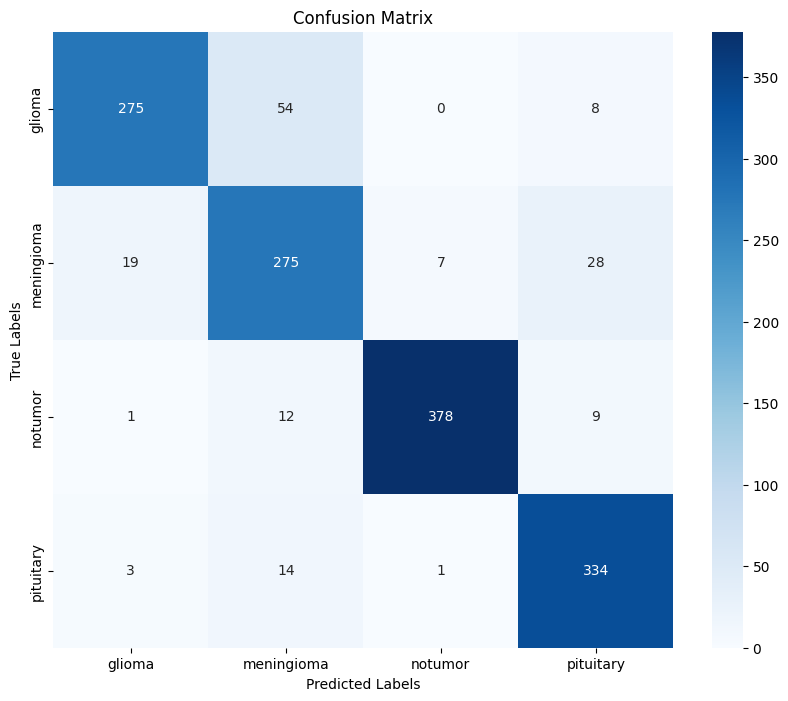

Classification Report:
               precision    recall  f1-score   support

      glioma       0.92      0.82      0.87       337
  meningioma       0.77      0.84      0.80       329
     notumor       0.98      0.94      0.96       400
   pituitary       0.88      0.95      0.91       352

    accuracy                           0.89      1418
   macro avg       0.89      0.89      0.89      1418
weighted avg       0.89      0.89      0.89      1418

Loss: 0.3970
Accuracy: 88.9986
Precision: 88.9986
Kappa Score: 85.3086


In [10]:
inception_loss, inception_accuracy, inception_precision, inception_kappa, confusion_inception, classification_inception = evaluate_model(inception_tf1, X_test, y_test, labels)


45/45 [==============================] - 3s 30ms/step - loss: 0.0232 - accuracy: 0.9944


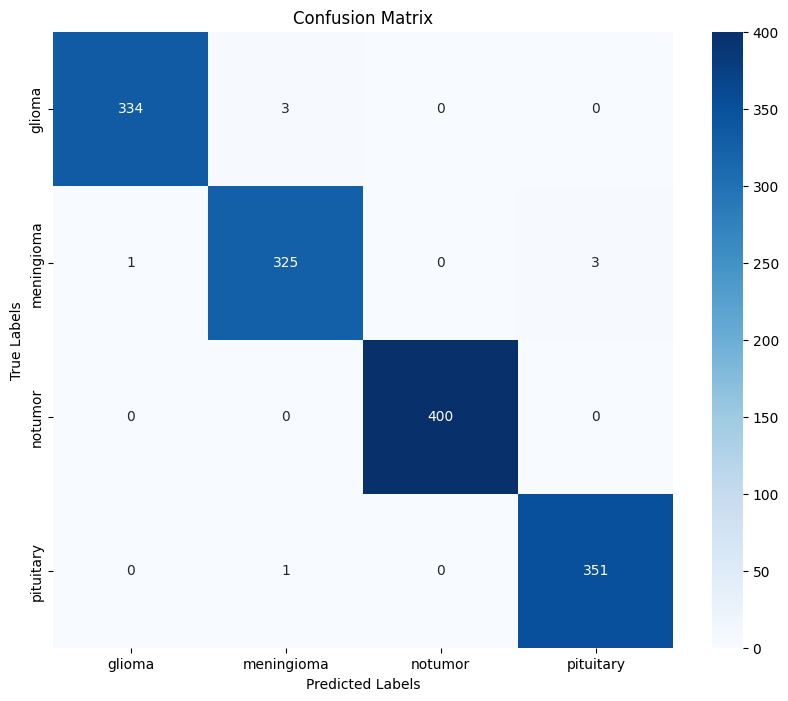

Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       337
  meningioma       0.99      0.99      0.99       329
     notumor       1.00      1.00      1.00       400
   pituitary       0.99      1.00      0.99       352

    accuracy                           0.99      1418
   macro avg       0.99      0.99      0.99      1418
weighted avg       0.99      0.99      0.99      1418

Loss: 0.0232
Accuracy: 99.4358
Precision: 99.4358
Kappa Score: 99.2462


In [11]:
inception_tf_loss, inception_tf_accuracy, inception_tf_precision, inception_tf_kappa, confusion_inception_tf, classification_inception_tf = evaluate_model(inception_tf2, X_test, y_test, labels)


45/45 [==============================] - 2s 40ms/step - loss: 1.3835 - accuracy: 0.2821


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


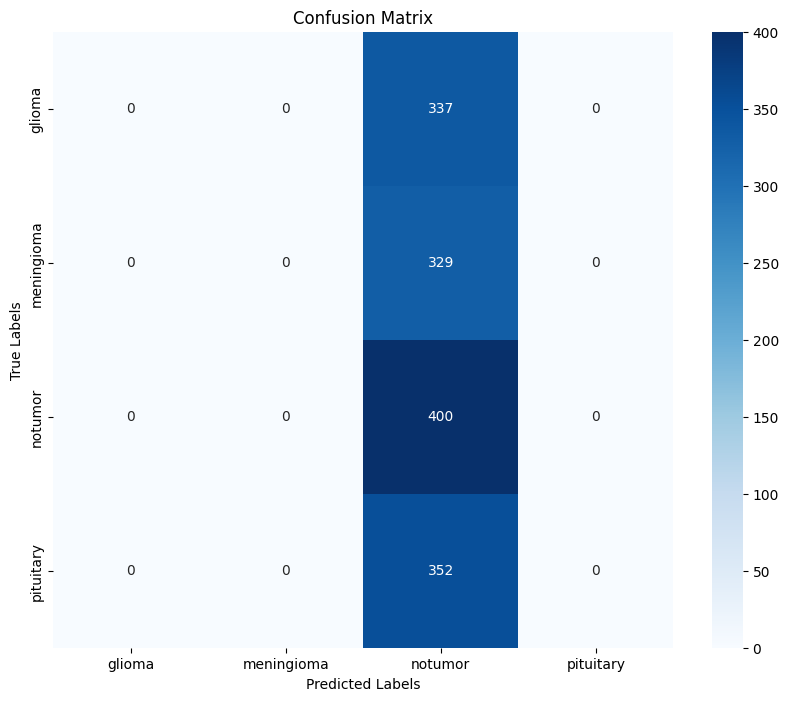

Classification Report:
               precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       337
  meningioma       0.00      0.00      0.00       329
     notumor       0.28      1.00      0.44       400
   pituitary       0.00      0.00      0.00       352

    accuracy                           0.28      1418
   macro avg       0.07      0.25      0.11      1418
weighted avg       0.08      0.28      0.12      1418

Loss: 1.3835
Accuracy: 28.2087
Precision: 28.2087
Kappa Score: 0.0000


In [12]:
# Evaluate VGG16 Modified model
vgg16_modified_loss, vgg16_modified_accuracy, vgg16_modified_precision, vgg16_modified_kappa, confusion_vgg16_modified, classification_vgg16_modified = evaluate_model(vgg16_not_tf, X_test, y_test, labels)


45/45 [==============================] - 3s 39ms/step - loss: 0.0471 - accuracy: 0.9901


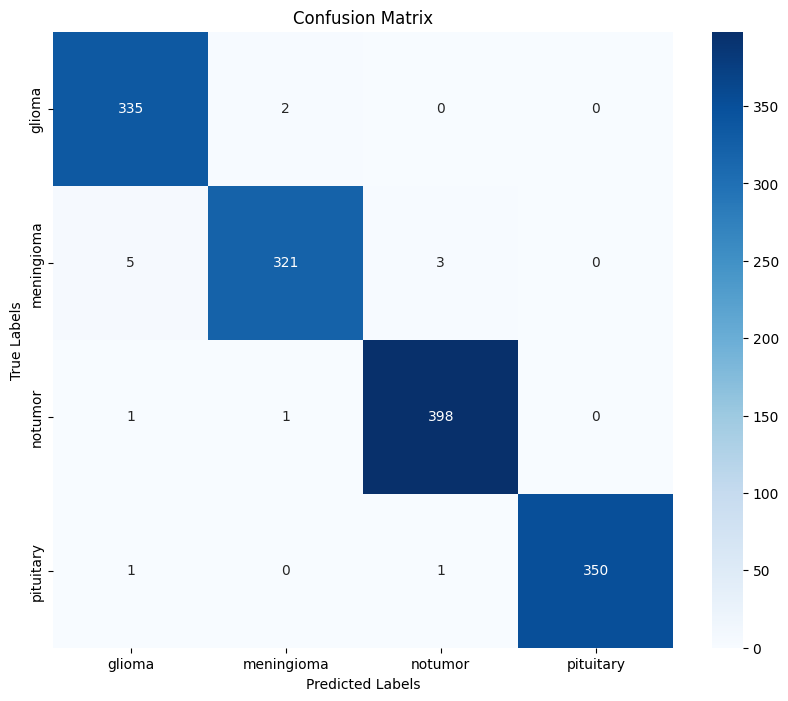

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       337
  meningioma       0.99      0.98      0.98       329
     notumor       0.99      0.99      0.99       400
   pituitary       1.00      0.99      1.00       352

    accuracy                           0.99      1418
   macro avg       0.99      0.99      0.99      1418
weighted avg       0.99      0.99      0.99      1418

Loss: 0.0471
Accuracy: 99.0127
Precision: 99.0127
Kappa Score: 98.6808


In [13]:

# Evaluate ResNet Modified model
resnet_modified_loss, resnet_modified_accuracy, resnet_modified_precision, resnet_modified_kappa, confusion_resnet_modified, classification_resnet_modified = evaluate_model(resnet_not_tf, X_test, y_test, labels)


45/45 [==============================] - 3s 30ms/step - loss: 0.0310 - accuracy: 0.9894


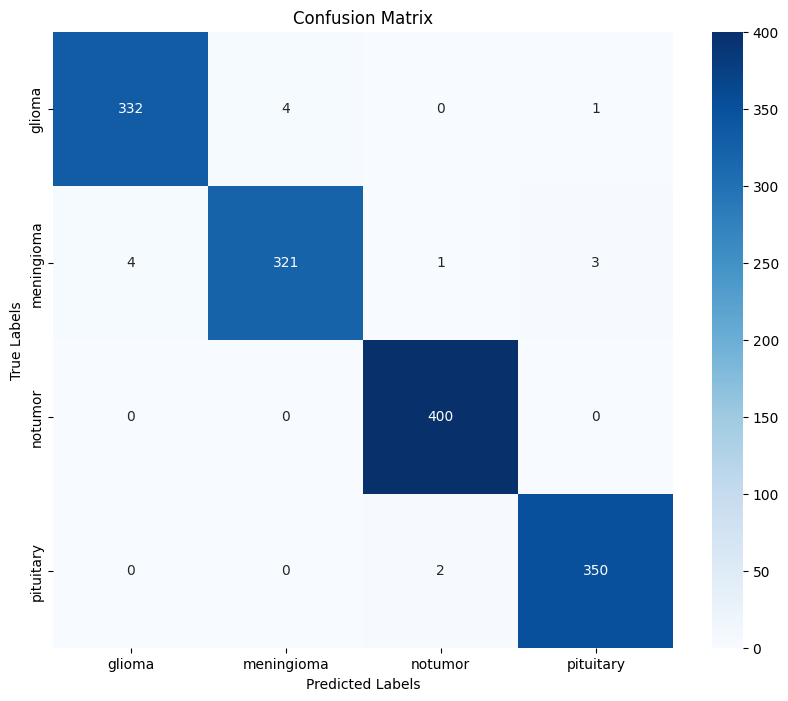

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       337
  meningioma       0.99      0.98      0.98       329
     notumor       0.99      1.00      1.00       400
   pituitary       0.99      0.99      0.99       352

    accuracy                           0.99      1418
   macro avg       0.99      0.99      0.99      1418
weighted avg       0.99      0.99      0.99      1418

Loss: 0.0310
Accuracy: 98.9422
Precision: 98.9422
Kappa Score: 98.5865


In [14]:

# Evaluate Inception Modified model
inception_modified_loss, inception_modified_accuracy, inception_modified_precision, inception_modified_kappa, confusion_inception_modified, classification_inception_modified = evaluate_model(inception_not_tf, X_test, y_test, labels)

In [15]:
from prettytable import PrettyTable

# Create a table
table = PrettyTable()
table.field_names = ["Model", "Loss", "Accuracy", "Precision", "Kappa"]

# Add rows to the table
table.add_row(["ResNet-tf1", resnet_loss, resnet_accuracy, resnet_precision, resnet_kappa])
table.add_row(["ResNet-not-tf", resnet_modified_loss, resnet_modified_accuracy, resnet_modified_precision, resnet_modified_kappa])
table.add_row(["ResNet-TF2", resnet_tf_loss, resnet_tf_accuracy, resnet_tf_precision, resnet_tf_kappa])
table.add_row(["VGG16-tf1", vgg16_loss, vgg16_accuracy, vgg16_precision, vgg16_kappa])
table.add_row(["VGG16-not-tf", vgg16_modified_loss, vgg16_modified_accuracy, vgg16_modified_precision, vgg16_modified_kappa])
table.add_row(["VGG16-tf2", vgg16_tf_loss, vgg16_tf_accuracy, vgg16_tf_precision, vgg16_tf_kappa])
table.add_row(["Inception-tf1", inception_loss, inception_accuracy, inception_precision, inception_kappa])
table.add_row(["Inception-not-tf", inception_modified_loss, inception_modified_accuracy, inception_modified_precision, inception_modified_kappa])
table.add_row(["Inception-tf2", inception_tf_loss, inception_tf_accuracy, inception_tf_precision, inception_tf_kappa])

# Print the table
print(table)


+------------------+----------------------+--------------------+--------------------+-------------------+
|      Model       |         Loss         |      Accuracy      |     Precision      |       Kappa       |
+------------------+----------------------+--------------------+--------------------+-------------------+
|    ResNet-tf1    |  0.8592376708984375  | 68.33568215370178  | 68.33568406205924  | 57.34121094888505 |
|  ResNet-not-tf   | 0.047053027898073196 | 99.01269674301147  | 99.01269393511988  | 98.68081978956378 |
|    ResNet-TF2    | 0.07701630890369415  | 97.95486330986023  | 97.95486600846263  |  97.2682165949099 |
|    VGG16-tf1     |  0.4137129485607147  | 88.43441605567932  | 88.43441466854725  |  84.5468898682161 |
|   VGG16-not-tf   |  1.383479118347168   | 28.208744525909424 | 28.208744710860366 |        0.0        |
|    VGG16-tf2     | 0.03728744387626648  | 98.87164831161499  |  98.8716502115656  | 98.49246064204644 |
|  Inception-tf1   |  0.3969716727733612  | 88

In [16]:
!pip install lime 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=12f727b4a9159d406be2190f47daabea93f80e78e765869201a5a3432e28e1d3
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [31]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image
import numpy as np

img = '/content/no tumor.jpg'
    # Load the image and resize it to 128,128
img = cv2.imread(img)
img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
img=img/255.0

# Define the Lime explainer
explainer = lime_image.LimeImageExplainer()

# Define the function to get the Lime explanation for a given model
def get_lime_explanation(model):
    # Define the predict function for the model
    predict_fn = lambda x: model.predict(x)
    
    # Get the explanation from Lime
    explanation = explainer.explain_instance(img, predict_fn, top_labels=1, hide_color=0, num_samples=1000)
    
    # Get the image and mask for the explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    
    # Return the masked image
    return mark_boundaries(temp / 2 + 0.5, mask)

# Get the Lime explanations for all the models
resnet_explanation = get_lime_explanation(resnet_tf1)
resnet_tf_explanation = get_lime_explanation(resnet_tf2)
vgg16_explanation = get_lime_explanation(vgg16_tf1)
vgg16_tf_explanation = get_lime_explanation(vgg16_tf2)
inception_explanation = get_lime_explanation(inception_tf1)
inception_tf_explanation = get_lime_explanation(inception_tf2)
################################
vgg16modified_explanation  = get_lime_explanation(vgg16_not_tf)
resnetmodified_explanation = get_lime_explanation(resnet_not_tf)
incepmodified_explanation = get_lime_explanation(inception_not_tf)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 32ms/step


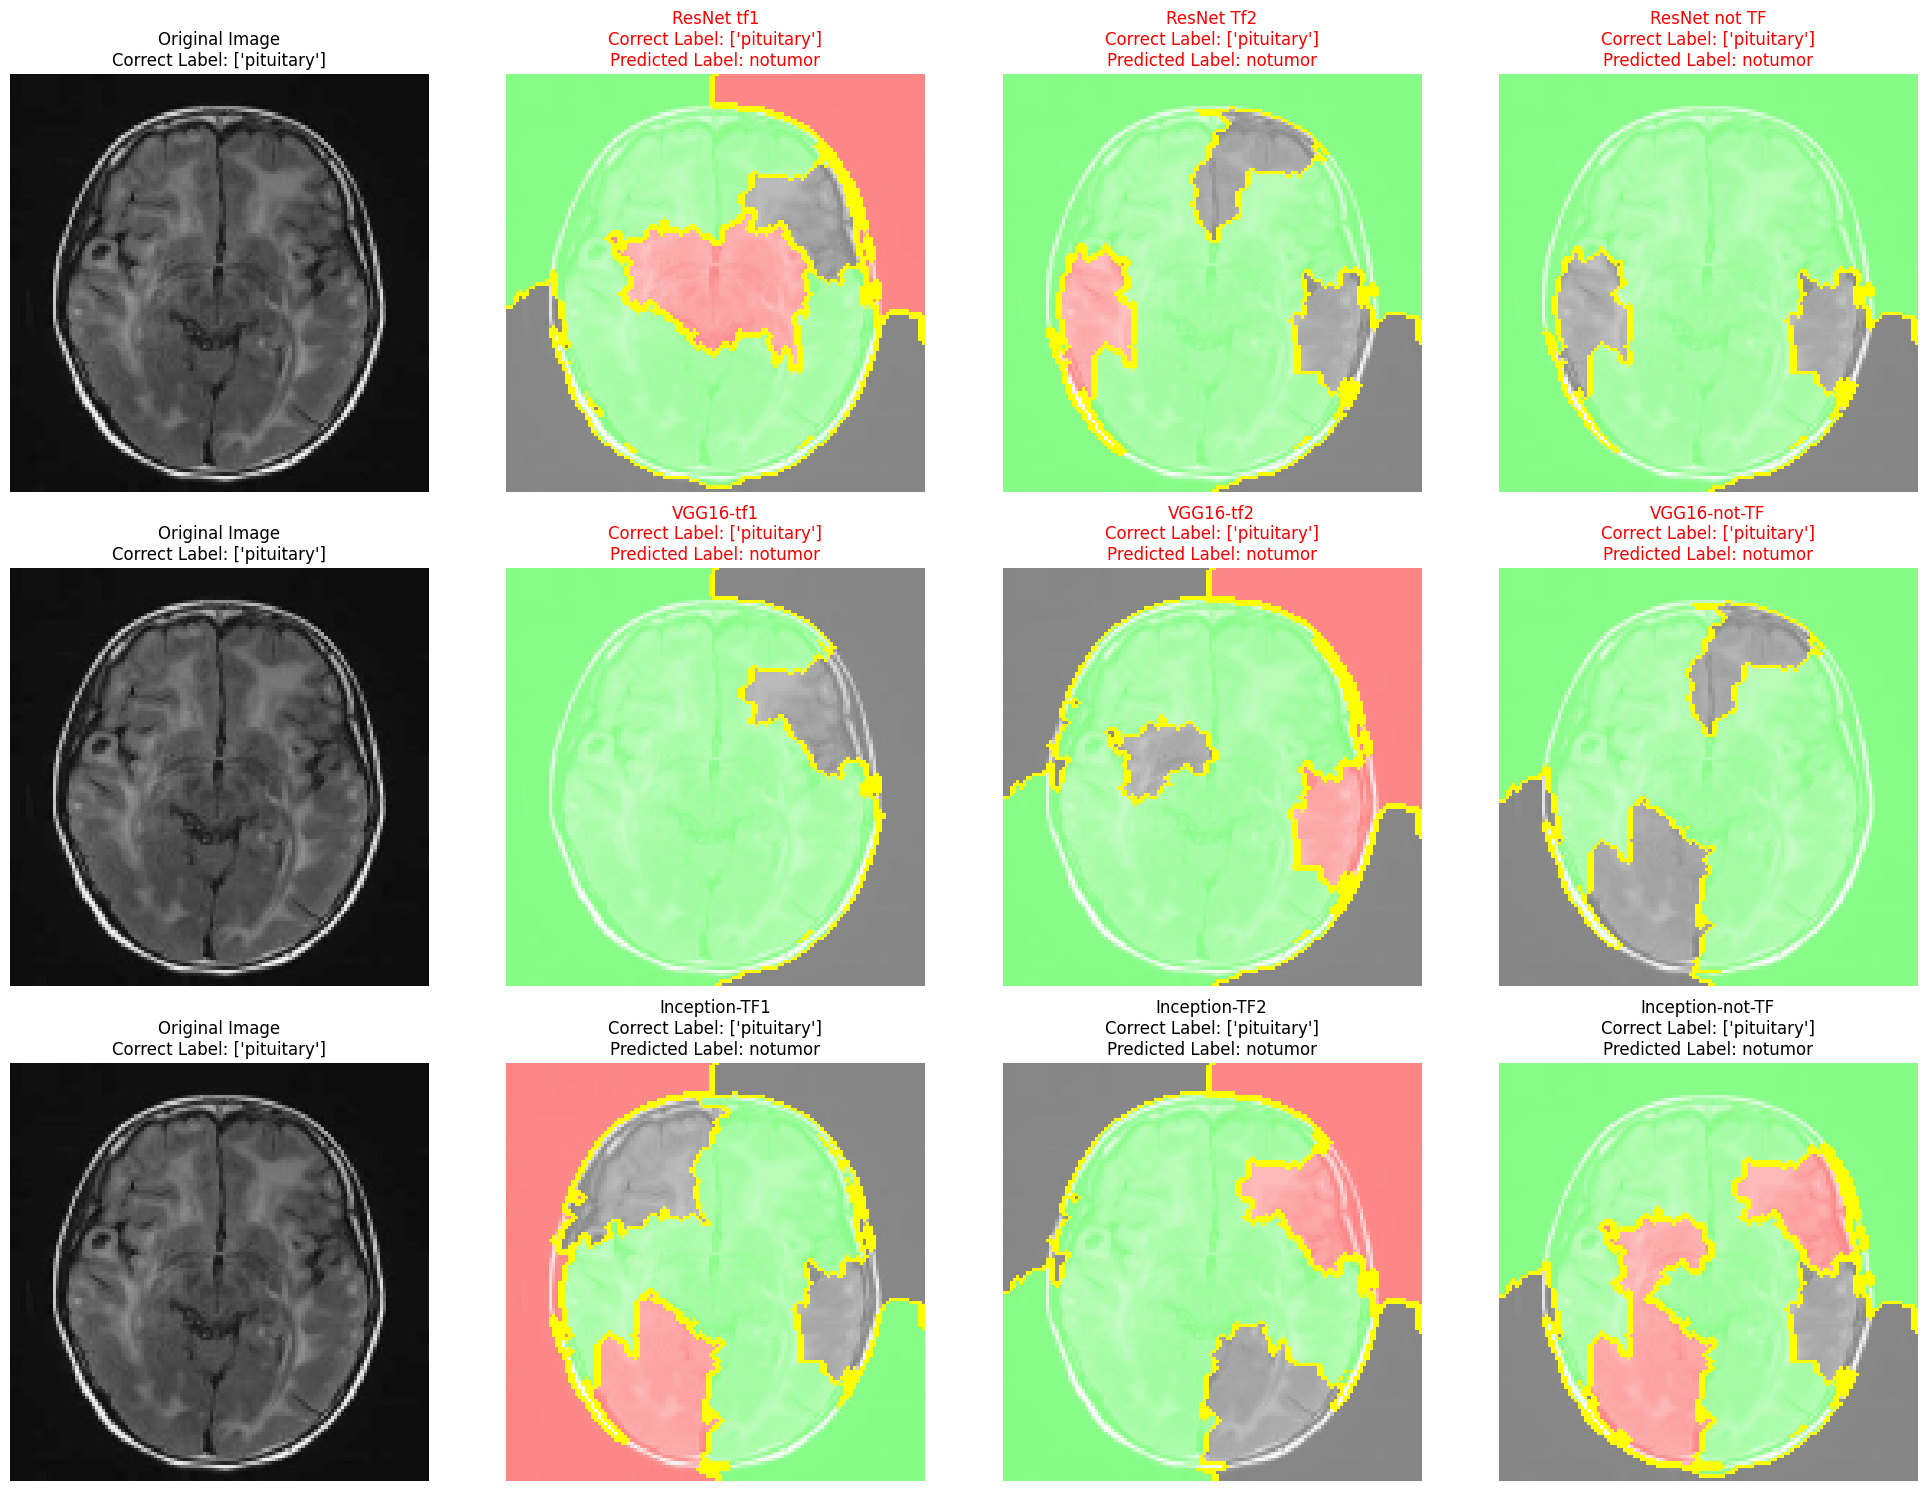

In [32]:
# Get the predicted labels for the original image
original_pred = 'notumor'
correct_label = 'notumor'

#Get the predicted labels for the original image

original_pred = 'pituitary'
correct_label = 'pituitary'
#Display the original image and the Lime explanations for all the models

fig, axs = plt.subplots(3, 4, figsize=(20, 15))
axs[0, 0].imshow(img)
axs[0, 0].set_title(f'Original Image\nCorrect Label: {[correct_label]}')
axs[0, 1].imshow(resnet_explanation)
resnet_pred = target[np.argmax(resnet_tf1.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[0, 1].set_title(f'ResNet tf1\nCorrect Label: {[correct_label]}\nPredicted Label: {resnet_pred}', color='red' if resnet_pred != correct_label else 'green')
axs[0, 2].imshow(resnet_tf_explanation)
resnet_tf_pred = target[np.argmax(resnet_tf2.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[0, 2].set_title(f'ResNet Tf2\nCorrect Label: {[correct_label]}\nPredicted Label: {resnet_tf_pred}', color='red' if resnet_tf_pred != correct_label else 'green')
axs[0, 3].imshow(resnetmodified_explanation)
resnet_not_tf_pred = target[np.argmax(resnet_not_tf.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[0, 3].set_title(f'ResNet not TF\nCorrect Label: {[correct_label]}\nPredicted Label: {resnet_not_tf_pred}', color='red' if resnet_not_tf_pred != correct_label else 'green')

axs[1, 0].imshow(img)
axs[1, 0].set_title(f'Original Image\nCorrect Label: {[correct_label]}')
axs[1, 1].imshow(vgg16_explanation)
vgg16_pred = target[np.argmax(vgg16_tf1.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[1, 1].set_title(f'VGG16-tf1\nCorrect Label: {[correct_label]}\nPredicted Label: {vgg16_pred}', color='red' if vgg16_pred != correct_label else 'green')
axs[1, 2].imshow(vgg16_tf_explanation)
vgg16_tf_pred = target[np.argmax(vgg16_tf2.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[1, 2].set_title(f'VGG16-tf2\nCorrect Label: {[correct_label]}\nPredicted Label: {vgg16_tf_pred}', color='red' if vgg16_tf_pred != correct_label else 'green')
axs[1, 3].imshow(vgg16modified_explanation)
vgg16_not_tf_pred = target[np.argmax(vgg16_not_tf.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[1, 3].set_title(f'VGG16-not-TF\nCorrect Label: {[correct_label]}\nPredicted Label: {vgg16_not_tf_pred}', color='red' if vgg16_not_tf_pred != correct_label else 'green')
axs[2, 0].imshow(img)
axs[2, 0].set_title(f'Original Image\nCorrect Label: {[correct_label]}')
axs[2, 1].imshow(inception_explanation)
inception_pred = np.argmax(inception_tf1.predict(np.expand_dims(img, axis=0)), axis=1)[0]
inception_correct = inception_pred == np.argmax(inception_tf2.predict(np.expand_dims(img, axis=0)), axis=1)[0]
if inception_correct:
  axs[2, 1].set_title(f'Inception-TF1\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}')
else:
  axs[2, 1].set_title(f'Inception-TF1\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}', color='red')

axs[2, 2].imshow(inception_tf_explanation)
inception_pred = np.argmax(inception_tf2.predict(np.expand_dims(img, axis=0)), axis=1)[0]
inception_correct = inception_pred == np.argmax(inception_not_tf.predict(np.expand_dims(img, axis=0)), axis=1)[0]
if inception_correct:
  axs[2, 2].set_title(f'Inception-TF2\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}')
else:
  axs[2, 2].set_title(f'Inception-TF2\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}', color='red')

axs[2, 3].imshow(incepmodified_explanation)
inception_pred = np.argmax(inception_not_tf.predict(np.expand_dims(img, axis=0)), axis=1)[0]
inception_correct = inception_pred == np.argmax(inception_tf1.predict(np.expand_dims(img, axis=0)), axis=1)[0]
if inception_correct:
  axs[2, 3].set_title(f'Inception-not-TF\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}')
else:
  axs[2, 3].set_title(f'Inception-not-TF\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}', color='red')

for ax in axs.flat:
  ax.axis('off')
plt.tight_layout()
plt.show()


In [20]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 42.7 MB/s eta 0:00:00


In [21]:
from PIL import ImageFont
import visualkeras
import keras
from IPython.display import display, Image

def generate_model_images(model):
    font = ImageFont.truetype("/content/drive/MyDrive/MODELS_MRI/Hack-Regular.ttf", 50, encoding="unic")
    
    visualkeras.layered_view(model, './model_diagram.png', legend=True, draw_volume=True, spacing=50, font=font)
    keras.utils.plot_model(model, './model_plot.png', show_shapes=True)
    
    with open('./model_diagram.png', 'rb') as f1, open('./model_plot.png', 'rb') as f2:
        model_diagram = Image(data=f1.read())
        model_plot = Image(data=f2.read())
    
    display(model_diagram, model_plot)


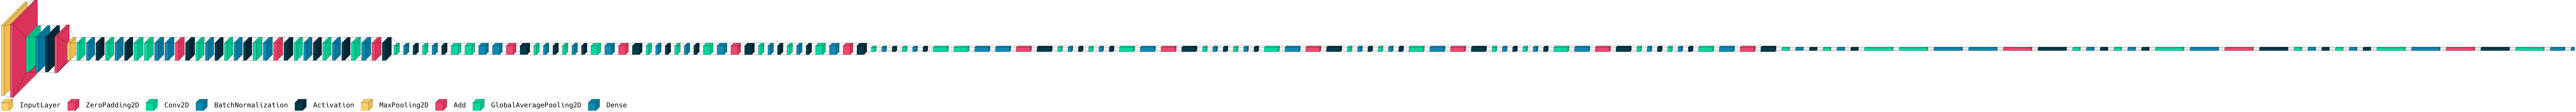

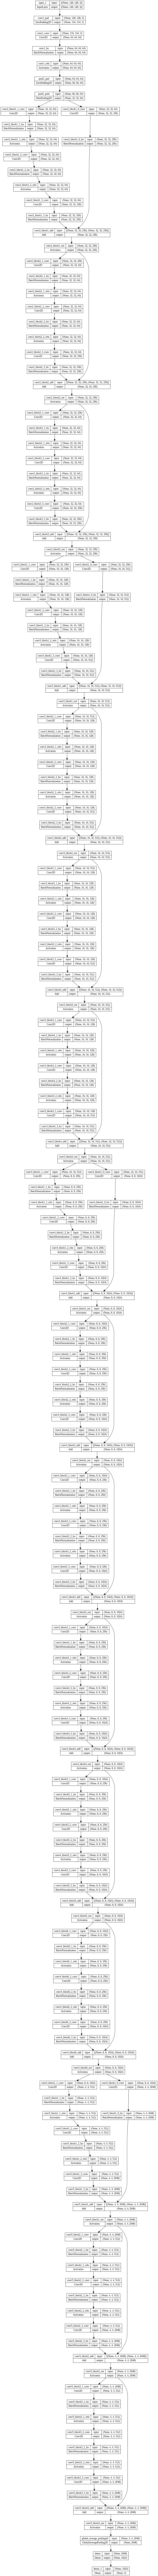

In [22]:
generate_model_images(resnet_not_tf)


In [23]:
from prettytable import PrettyTable

def count_parameters(model):
    total_params = 0
    trainable_params = 0
    non_trainable_params = 0
    params_dict = {}
    for layer in model.layers:
        layer_params = layer.count_params()
        params_dict[layer.name] = layer_params
        total_params += layer_params
        if layer.trainable:
            trainable_params += layer_params
        else:
            non_trainable_params += layer_params
    return total_params, trainable_params, non_trainable_params, params_dict

models = {'inception_not_tf': inception_not_tf,
          'resnet_not_tf': resnet_not_tf,
          'vgg16_not_tf': vgg16_not_tf,
          'inception_tf2': inception_tf2,
          'inception_tf1': inception_tf1,
          'vgg16_tf2': vgg16_tf2,
          'vgg16_tf1': vgg16_tf1,
          'resnet_tf2': resnet_tf2,
          'resnet_tf1': resnet_tf1}

table = PrettyTable()
table.field_names = ['Model', 'Total Parameters', 'Trainable Parameters', 'Non-Trainable Parameters']
for model_name, model in models.items():
    total_params, trainable_params, non_trainable_params, layer_params = count_parameters(model)
    table.add_row([model_name, total_params, trainable_params, non_trainable_params])

print(table)


+------------------+------------------+----------------------+--------------------------+
|      Model       | Total Parameters | Trainable Parameters | Non-Trainable Parameters |
+------------------+------------------+----------------------+--------------------------+
| inception_not_tf |     23905060     |       23905060       |            0             |
|  resnet_not_tf   |     25689988     |       25689988       |            0             |
|   vgg16_not_tf   |     15244100     |       15244100       |            0             |
|  inception_tf2   |     23905060     |       23905060       |            0             |
|  inception_tf1   |     23905060     |       2102276        |         21802784         |
|    vgg16_tf2     |     15244100     |       15244100       |            0             |
|    vgg16_tf1     |     15244100     |        529412        |         14714688         |
|    resnet_tf2    |     25689988     |       25689988       |            0             |
|    resne

In [24]:
num_layers = len(resnet_not_tf.layers)
print(f"Number of layers: {num_layers}")


Number of layers: 178


In [25]:
def separate_layers(model):
    conv_layers = []
    dense_layers = []
    activation_layers = []
    normalization_layers = []
    other_layers = []

    for layer in model.layers:
        layer_type = type(layer).__name__

        if "Conv2D" in layer_type:
            conv_layers.append(layer)
        elif "Dense" in layer_type:
            dense_layers.append(layer)
        elif "Activation" in layer_type:
            activation_layers.append(layer)
        elif "Normalization" in layer_type:
            normalization_layers.append(layer)
        else:
            other_layers.append(layer)

    return conv_layers, dense_layers, activation_layers, normalization_layers, other_layers


In [26]:
from prettytable import PrettyTable

# define models
models = {
    "inception_not_tf": inception_not_tf,
    "resnet_not_tf": resnet_not_tf,
    "vgg16_not_tf": vgg16_not_tf,
    "inception_tf2": inception_tf2,
    "inception_tf1": inception_tf1,
    "vgg16_tf2": vgg16_tf2,
    "vgg16_tf1": vgg16_tf1,
    "resnet_tf2": resnet_tf2,
    "resnet_tf1": resnet_tf1
}

# create table and add column headers
table = PrettyTable()
table.field_names = ["Model Name", "Conv Layers", "Dense Layers", "Activation Layers", "Normalization Layers", "Other Layers"]

# loop over models
for model_name, model in models.items():
    # get layer lists
    conv_layers, dense_layers, activation_layers, normalization_layers, other_layers = separate_layers(model)
    
    # add row to table
    table.add_row([model_name, len(conv_layers), len(dense_layers), len(activation_layers), len(normalization_layers), len(other_layers)])

# display table
print(table)


+------------------+-------------+--------------+-------------------+----------------------+--------------+
|    Model Name    | Conv Layers | Dense Layers | Activation Layers | Normalization Layers | Other Layers |
+------------------+-------------+--------------+-------------------+----------------------+--------------+
| inception_not_tf |      94     |      2       |         94        |          94          |      30      |
|  resnet_not_tf   |      53     |      2       |         49        |          53          |      21      |
|   vgg16_not_tf   |      13     |      2       |         0         |          0           |      7       |
|  inception_tf2   |      94     |      2       |         94        |          94          |      30      |
|  inception_tf1   |      94     |      2       |         94        |          94          |      30      |
|    vgg16_tf2     |      13     |      2       |         0         |          0           |      7       |
|    vgg16_tf1     |      13

In [27]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image
import numpy as np

img = '/content/Te-pi_0147.jpg'
    # Load the image and resize it to 128,128
img = cv2.imread(img)
img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
img=img/255.0

# Define the Lime explainer
explainer = lime_image.LimeImageExplainer()

# Define the function to get the Lime explanation for a given model
def get_lime_explanation(model):
    # Define the predict function for the model
    predict_fn = lambda x: model.predict(x)
    
    # Get the explanation from Lime
    explanation = explainer.explain_instance(img, predict_fn, top_labels=1, hide_color=0, num_samples=1000)
    
    # Get the image and mask for the explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    
    # Return the masked image
    return mark_boundaries(temp / 2 + 0.5, mask)

# Get the Lime explanations for all the models
resnet_explanation = get_lime_explanation(resnet_tf1)
resnet_tf_explanation = get_lime_explanation(resnet_tf2)
vgg16_explanation = get_lime_explanation(vgg16_tf1)
vgg16_tf_explanation = get_lime_explanation(vgg16_tf2)
inception_explanation = get_lime_explanation(inception_tf1)
inception_tf_explanation = get_lime_explanation(inception_tf2)
################################
vgg16modified_explanation  = get_lime_explanation(vgg16_not_tf)
resnetmodified_explanation = get_lime_explanation(resnet_not_tf)
incepmodified_explanation = get_lime_explanation(inception_not_tf)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 26ms/step


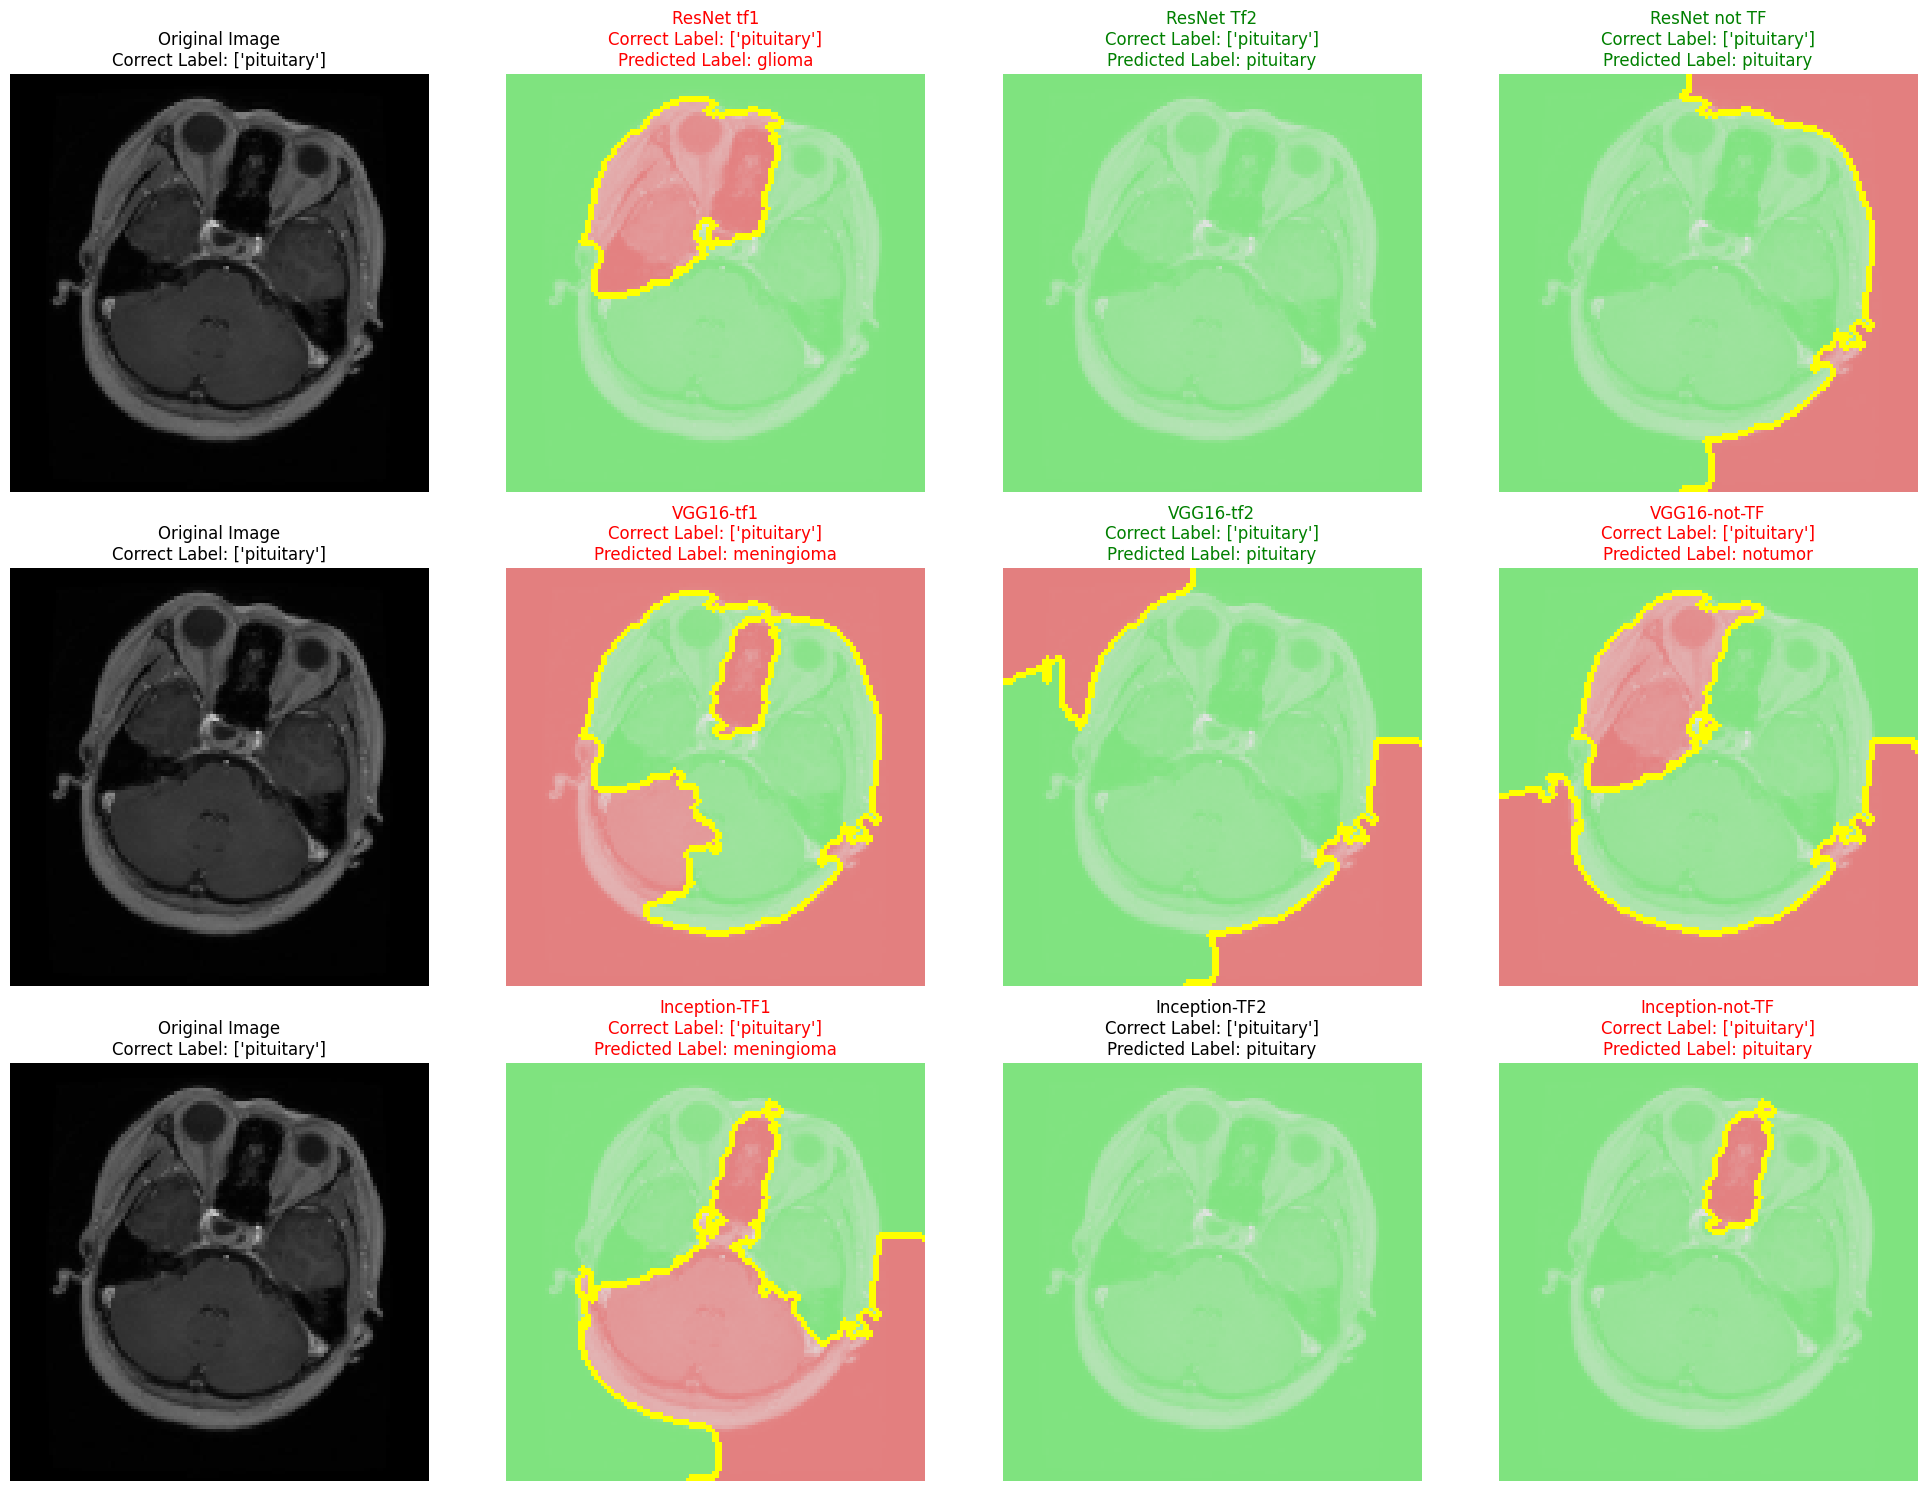

In [30]:
#Get the predicted labels for the original image

original_pred = 'pituitary'
correct_label = 'pituitary'
#Display the original image and the Lime explanations for all the models

fig, axs = plt.subplots(3, 4, figsize=(20, 15))
axs[0, 0].imshow(img)
axs[0, 0].set_title(f'Original Image\nCorrect Label: {[correct_label]}')
axs[0, 1].imshow(resnet_explanation)
resnet_pred = target[np.argmax(resnet_tf1.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[0, 1].set_title(f'ResNet tf1\nCorrect Label: {[correct_label]}\nPredicted Label: {resnet_pred}', color='red' if resnet_pred != correct_label else 'green')
axs[0, 2].imshow(resnet_tf_explanation)
resnet_tf_pred = target[np.argmax(resnet_tf2.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[0, 2].set_title(f'ResNet Tf2\nCorrect Label: {[correct_label]}\nPredicted Label: {resnet_tf_pred}', color='red' if resnet_tf_pred != correct_label else 'green')
axs[0, 3].imshow(resnetmodified_explanation)
resnet_not_tf_pred = target[np.argmax(resnet_not_tf.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[0, 3].set_title(f'ResNet not TF\nCorrect Label: {[correct_label]}\nPredicted Label: {resnet_not_tf_pred}', color='red' if resnet_not_tf_pred != correct_label else 'green')

axs[1, 0].imshow(img)
axs[1, 0].set_title(f'Original Image\nCorrect Label: {[correct_label]}')
axs[1, 1].imshow(vgg16_explanation)
vgg16_pred = target[np.argmax(vgg16_tf1.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[1, 1].set_title(f'VGG16-tf1\nCorrect Label: {[correct_label]}\nPredicted Label: {vgg16_pred}', color='red' if vgg16_pred != correct_label else 'green')
axs[1, 2].imshow(vgg16_tf_explanation)
vgg16_tf_pred = target[np.argmax(vgg16_tf2.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[1, 2].set_title(f'VGG16-tf2\nCorrect Label: {[correct_label]}\nPredicted Label: {vgg16_tf_pred}', color='red' if vgg16_tf_pred != correct_label else 'green')
axs[1, 3].imshow(vgg16modified_explanation)
vgg16_not_tf_pred = target[np.argmax(vgg16_not_tf.predict(np.expand_dims(img, axis=0)), axis=1)[0]]
axs[1, 3].set_title(f'VGG16-not-TF\nCorrect Label: {[correct_label]}\nPredicted Label: {vgg16_not_tf_pred}', color='red' if vgg16_not_tf_pred != correct_label else 'green')
axs[2, 0].imshow(img)
axs[2, 0].set_title(f'Original Image\nCorrect Label: {[correct_label]}')
axs[2, 1].imshow(inception_explanation)
inception_pred = np.argmax(inception_tf1.predict(np.expand_dims(img, axis=0)), axis=1)[0]
inception_correct = inception_pred == np.argmax(inception_tf2.predict(np.expand_dims(img, axis=0)), axis=1)[0]
if inception_correct:
  axs[2, 1].set_title(f'Inception-TF1\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}')
else:
  axs[2, 1].set_title(f'Inception-TF1\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}', color='red')

axs[2, 2].imshow(inception_tf_explanation)
inception_pred = np.argmax(inception_tf2.predict(np.expand_dims(img, axis=0)), axis=1)[0]
inception_correct = inception_pred == np.argmax(inception_not_tf.predict(np.expand_dims(img, axis=0)), axis=1)[0]
if inception_correct:
  axs[2, 2].set_title(f'Inception-TF2\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}')
else:
  axs[2, 2].set_title(f'Inception-TF2\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}', color='red')

axs[2, 3].imshow(incepmodified_explanation)
inception_pred = np.argmax(inception_not_tf.predict(np.expand_dims(img, axis=0)), axis=1)[0]
inception_correct = inception_pred == np.argmax(inception_tf1.predict(np.expand_dims(img, axis=0)), axis=1)[0]
if inception_correct:
  axs[2, 3].set_title(f'Inception-not-TF\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}')
else:
  axs[2, 3].set_title(f'Inception-not-TF\nCorrect Label: {[correct_label]}\nPredicted Label: {target[inception_pred]}', color='red')

for ax in axs.flat:
  ax.axis('off')
plt.tight_layout()
plt.show()
